# Отток клиентов телеком-оператора

## Цель и этапы проекта

Цель исследования — построить модель для предсказания возможного оттока клиентов для мобильного оператора.

*Этапы исследования*

1. Провести обзор данных, выделить или создать целевую переменную
2. Объединить имеющиеся данные в один датасет для исследования
3. Проанализировать признаки на предмет наличия пропусков и аномалий, при их наличии заполнить пропуски и устранить аномалии
4. Проанализировать признаки на предмет наличия корреляции с целевой переменной, удалить незначимые признаки и, возможно, создать новые на основе имеющихся данных (при использовании линейной модели провести исследование на мультиколлинеарность признаков и удалить сильно коррелирующие между собой признаки)
5. Разбить данные на тренировочный и тестовый наборы
6. Закодировать категориальные признаки
7. Обучить 3 модели машинного обучения, проверить их качество кросс-валидацией
8. Проверить модель с наилучшей метрикой на тестовой выборке
9. Проанализировать важность признаков для моделей (feature importance)



### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Для создания целевой переменной мы будем использовать признак `EndDate`, который находится в датасете `contract_new`.

Считаем данные в отдельные переменные и сделаем функцию для обзора данных.

## Обзор данных

In [1]:
# ! pip install lightgbm -q
# ! pip install phik -q

In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, auc, confusion_matrix
)
from sklearn.model_selection import (
    RandomizedSearchCV, train_test_split, cross_val_predict, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

plt.style.use('dark_background')

In [3]:
#задаем константу для random_state
STATE=240423

In [4]:
# считываем данные
try:
    contract = pd.read_csv('/content/contract_new.csv', index_col = ['customerID'],
                           parse_dates=['BeginDate'])
    internet = pd.read_csv('/content/internet_new.csv', index_col = ['customerID'])
    persons = pd.read_csv('/content/personal_new.csv', index_col = ['customerID'])
    phone = pd.read_csv('/content/phone_new.csv', index_col = ['customerID'])
except:
    contract = pd.read_csv('/datasets/contract_new.csv', index_col = ['customerID'],
                           parse_dates=['BeginDate'])
    internet = pd.read_csv('/datasets/internet_new.csv', index_col = ['customerID'])
    persons = pd.read_csv('/datasets/personal_new.csv', index_col = ['customerID'])
    phone = pd.read_csv('/datasets/phone_new.csv', index_col = ['customerID'])
    
    

In [5]:
# функция для обзора данных

def data_overview(data):
    '''
    Функция принимает на вход датафрейм и выводит основную информацию по нему
    '''
    print('Первые пять строк', (80 - len('Первые пять строк')) * '-')
    display(data.head())   
    print('')
    print('Общая информация о данных (info)', (80 - len('Общая информация о данных (info)')) * '-', '\n')
    data.info()
    print('')
    print('Статистические показатели (describe)', (80 - len('Статистические показатели (describe)')) * '-')
    display(data.describe(include='object').T)
    print('')
    print('Пропуски в данных', (80 - len('Пропуски в данных')) * '-', '\n')
    print(data.isna().sum())
    print('')
    print('Дубликаты в данных', (80 - len('Дубликаты в данных')) * '-', '\n')
    print(data.duplicated().sum())
    
    

In [6]:
data_overview(contract)

Первые пять строк ---------------------------------------------------------------


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB

Статистические показатели (describe) --------------------------------------------


,count,unique,top,freq
EndDate,7043,67,No,5942
Type,7043,3,Month-to-month,3875
PaperlessBilling,7043,2,Yes,4171
PaymentMethod,7043,4,Electronic check,2365
TotalCharges,7043,6658,,11



Пропуски в данных --------------------------------------------------------------- 

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Дубликаты в данных -------------------------------------------------------------- 

37


В первом датасете, где содержатся данные о контрактах, отсутствуют пропуски и дубликаты. В нем 7043 записи. Во всех столбцах, кроме `MonthlyCharges` и `BeginDate`, тип данных _object_. Изменим тип данных в соответствии со значениями в столбце `TotalCharges` (приведем данные к типу _float_).

In [7]:
#contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

При попытке изменить тип данных на _float_ в столбце `TotalCharges` возникает ошибка из-за наличия пустых строк в столбце. Заменим пустые строки на 0 и изменим тип данных.

In [8]:
contract['TotalCharges'] = contract['TotalCharges'].replace(" ", 0).astype('float64')

Посмотрим на столбец с конечной датой (`EndDate`).

In [9]:
contract.EndDate.nunique()

67

In [10]:
contract.EndDate[contract.EndDate != 'No']

customerID
6388-TABGU    2017-05-01
3655-SNQYZ    2016-03-01
6865-JZNKO    2018-09-01
3841-NFECX    2018-11-01
6234-RAAPL    2018-12-01
                 ...    
6075-SLNIL    2019-02-01
9347-AERRL    2019-12-01
0093-XWZFY    2019-05-01
6691-CCIHA    2018-04-01
0639-TSIQW    2015-11-01
Name: EndDate, Length: 1101, dtype: object

Как видим, в столбце содержатся значения _No_, если человек еще является клиентом оператора, и дата расторжения договора, если человек клиентом больше не является. Заменим даты на значение 1 (клиент ушел), а No — на 0 (клиент не ушел). Создадим для этого отдельный столбец с целевым признаком.

In [11]:
contract['churn'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Посмотрим, есть ли дисбаланс в целевом признаке.

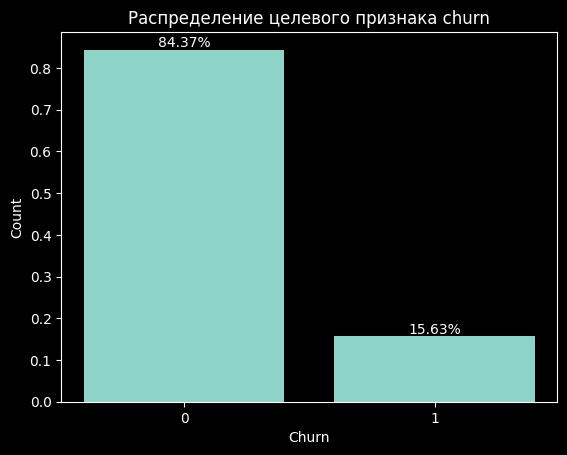

In [12]:
# строим график для столбца с целевым признаком

fig, ax = plt.subplots()
counts = contract['churn'].value_counts(normalize=True)
ax.bar(counts.index, counts.values)
ax.set_xticks([0,1])
ax.set_xticklabels(['0', '1'])
for i, count in enumerate(counts.values):
    ax.text(i, count, f'{count:.2%}', ha='center', va='bottom')
plt.title('Распределение целевого признака churn')
plt.xlabel('Churn')
plt.ylabel('Count')

plt.show()

В целевом признаке имеется дисбаланс.

Посмотрим на второй датасет.

In [13]:
data_overview(internet)

Первые пять строк ---------------------------------------------------------------


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No



Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB

Статистические показатели (describe) --------------------------------------------


,count,unique,top,freq
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785



Пропуски в данных --------------------------------------------------------------- 

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Дубликаты в данных -------------------------------------------------------------- 

5389


В датасете с данными об интернет-услугах содержится 5517 записей (меньше, чем в первом датасете с данными о контрактах), пропусков и дубликатов нет. Все данные типа _object_. 

Посмотрим на датасет с персональными данными.

In [14]:
data_overview(persons)

Первые пять строк ---------------------------------------------------------------


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No



Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB

Статистические показатели (describe) --------------------------------------------


,count,unique,top,freq
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933



Пропуски в данных --------------------------------------------------------------- 

gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Дубликаты в данных -------------------------------------------------------------- 

7027


В датасете с персональными данными 7043 записи (столько же, сколько в датасете с данными о контрактах). Пропусков и дубликатов нет. Данные во всех столбцах, кроме `SeniorCitizen`, имеют тип _object_. 

Остался последний датасет — `phone`.

In [15]:
data_overview(phone)

Первые пять строк ---------------------------------------------------------------


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes



Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB

Статистические показатели (describe) --------------------------------------------


,count,unique,top,freq
MultipleLines,6361,2,No,3390



Пропуски в данных --------------------------------------------------------------- 

MultipleLines    0
dtype: int64

Дубликаты в данных -------------------------------------------------------------- 

6359


В датасете `phone` 6361 запись (меньше, чем в датасете с данными о контрактах). Пропусков и дубликатов в данных нет. Здесь всего два столбца — `customerID` (индекс) и `MultipleLines`. В обоих тип данных — _object_.

### Вывод по разделу

На этапе обзора данных было сделано следующее:
1. Изменен тип данных, где необходимо
2. Подготовлен целевой признак на основе данных из столбца `EndDate`
3. Обнаружен дисбаланс в целевом признаке

## Подготовка данных


Объединим имеющиеся у нас датасеты в один.

In [16]:
full_data = contract.merge(internet, left_index=True, right_index=True, how='left') \
               .merge(persons, left_index=True, right_index=True, how='left') \
               .merge(phone, left_index=True, right_index=True, how='left')


In [17]:
full_data

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,0,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,0,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,0,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN


Поскольку в датасетах разное количество строк, в данных после объединения будут пропуски.

In [18]:
full_data.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
churn                  0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Вероятнее всего, пропуски в данных означают, что данная услуга у клиента не подключена (он ее не использует), следовательно, мы можем заменить их на значение _No_.

In [19]:
full_data = full_data.fillna('No')
full_data.isna().any().sum()

0

Пропусков в данных не осталось.

У нас есть признаки `BeginDate` и `EndDate`. На их основе мы можем создать признак, отражающий период использования клиентом услуг оператора, а сами даты можно будет удалить. Сначала заменим значение _No_ в `EndDate` на _01.02.2020_, поскольку в комментарии к данным указано, что информация актуальна на эту дату.

In [20]:
# заменяем значение No на дату актуальности данных
full_data.EndDate = full_data.EndDate.replace('No', '2020-02-01')

In [21]:
# приводим данные к типу datetime
full_data.EndDate = pd.to_datetime(full_data.EndDate)

In [22]:
# вычисляем период (в днях)
full_data['period'] = (full_data.EndDate - full_data.BeginDate).dt.days

In [23]:
# удаляем столбцы с датами
full_data = full_data.drop(['EndDate', 'BeginDate'], axis=1)

In [24]:
# функция для построения нормированных гистограмм в разрезе целевой переменной
def plot_normalized_histogram(data, x, hue='churn'):
    '''
    Функция для построения нормированных гистограмм в разрезе целевой переменной.
    
    Аргументы:
    - data (pandas.DataFrame): набор данных
    - x (str): название столбца с данными для гистограммы
    - hue (str): название столбца, по которому будет происходить разбивка данных
    '''
    
    g = sns.FacetGrid(data, hue=hue, height=5, aspect=2)
    g.map(sns.histplot, x, alpha=.5, bins=20)
    
    for cat in data[hue].unique():
        normed_histogram = (data[data[hue] == cat][x]
                            .value_counts(normalize=True).sort_index()
        )
        g.axes[0][0].plot(normed_histogram.index, 
                          normed_histogram.values, 
                          linestyle='--', 
                          marker='o', markersize=3)
    g.add_legend()
    g.fig.suptitle(f'Распределение признака {x} в разрезе {hue}')




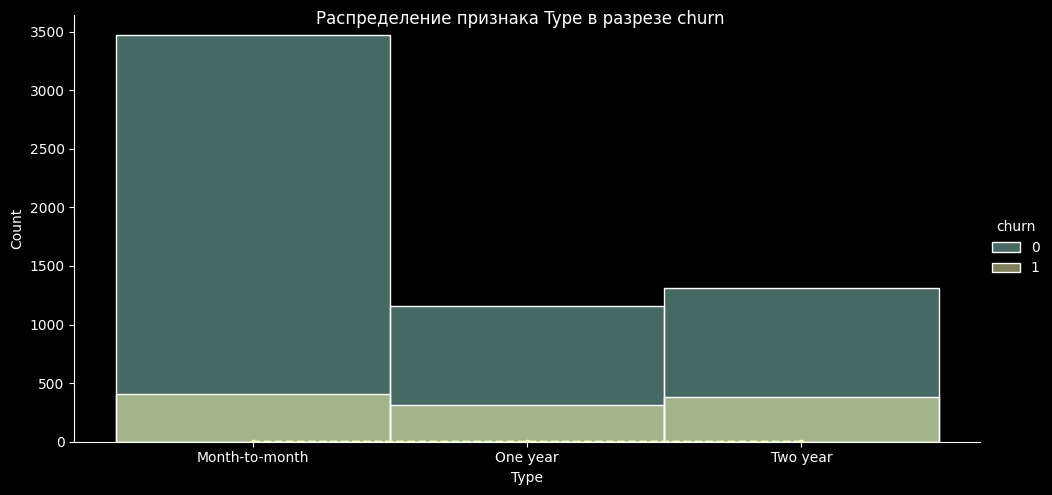

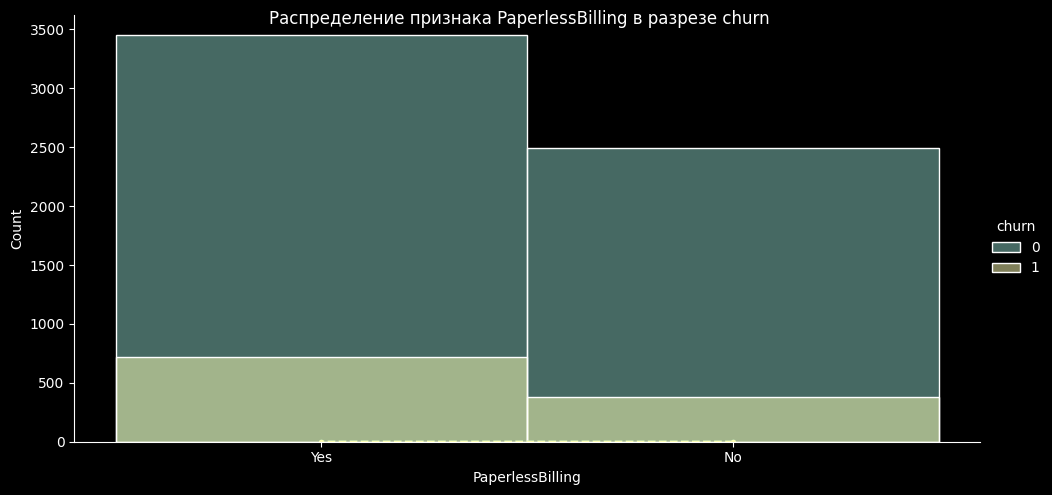

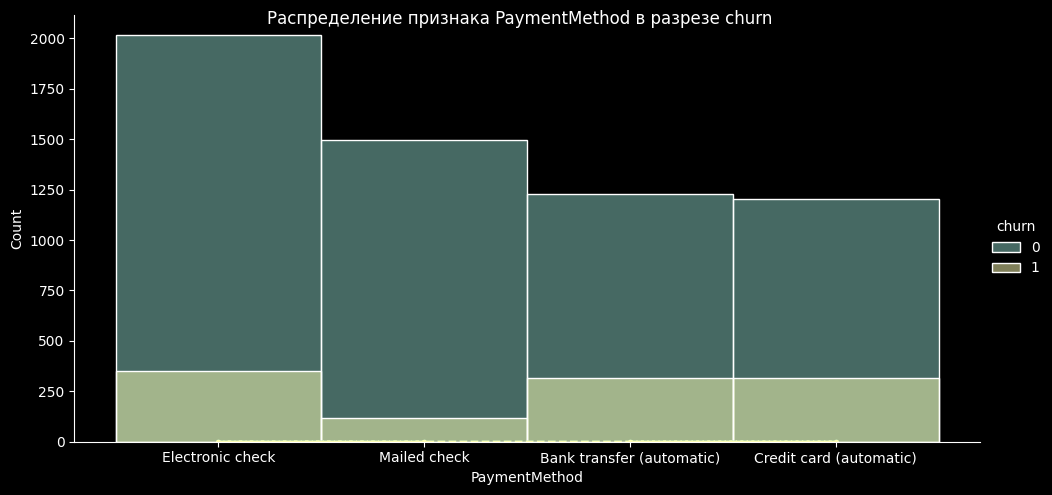

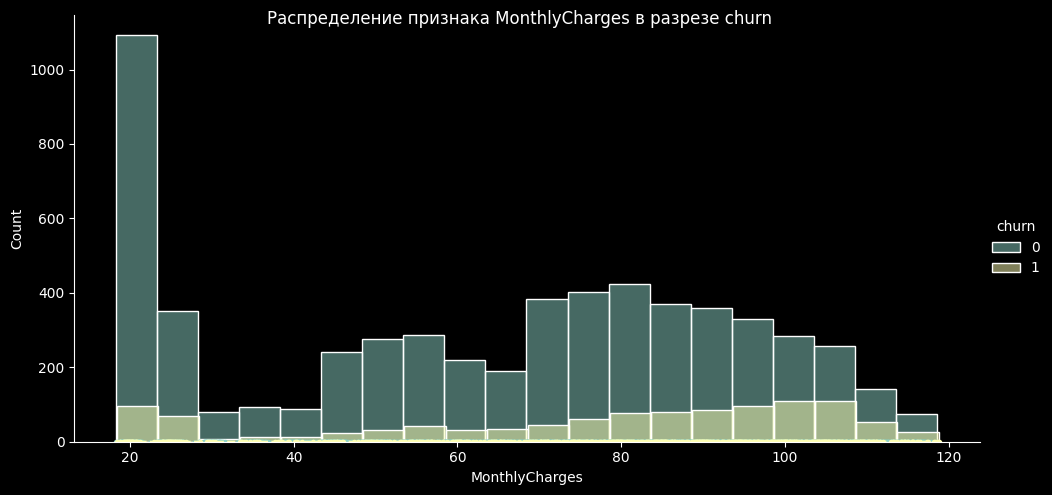

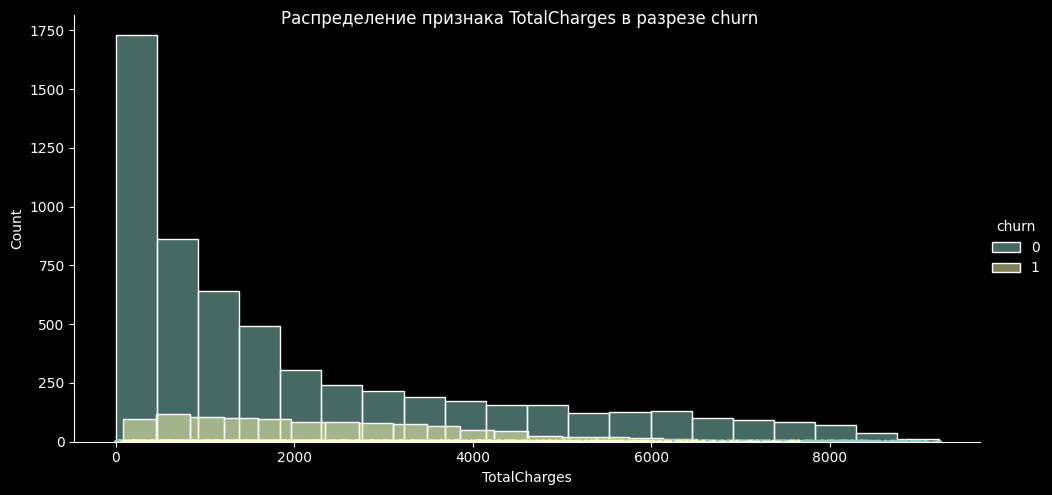

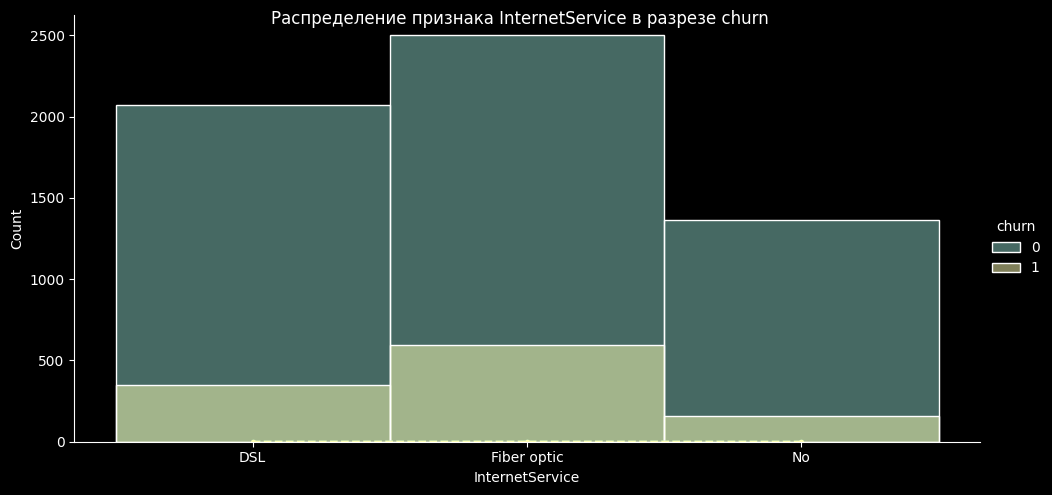

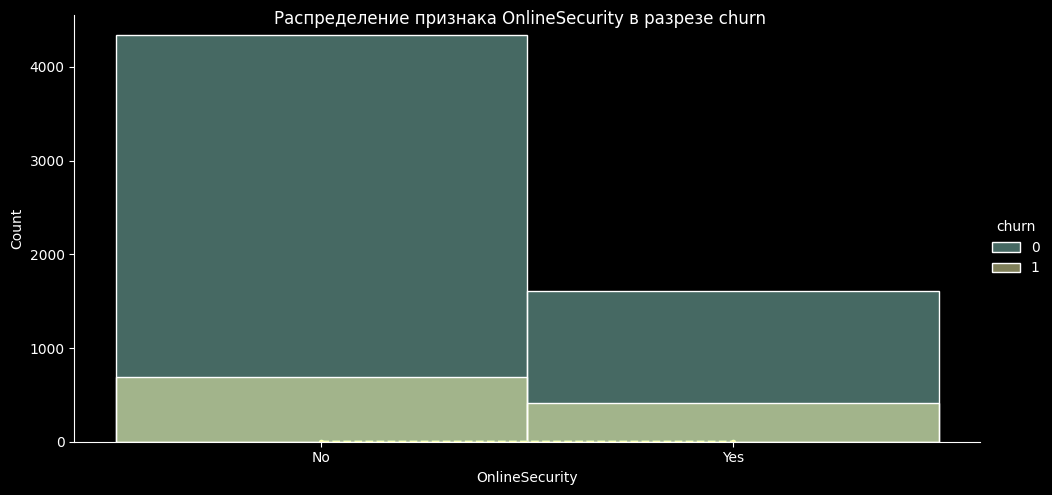

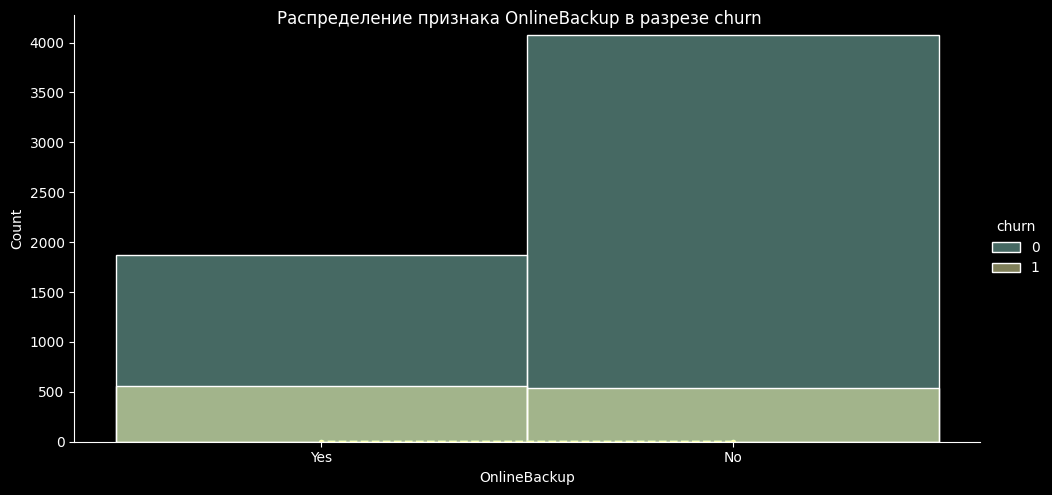

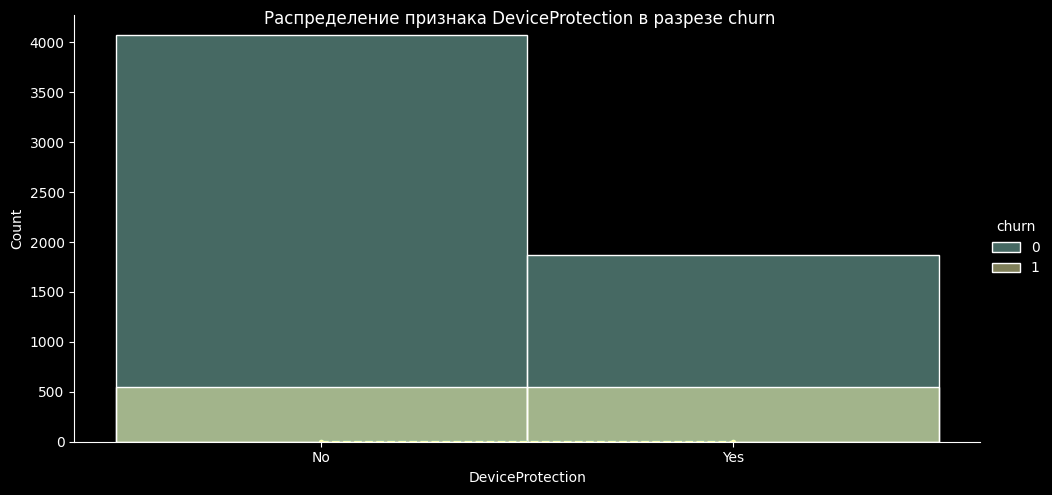

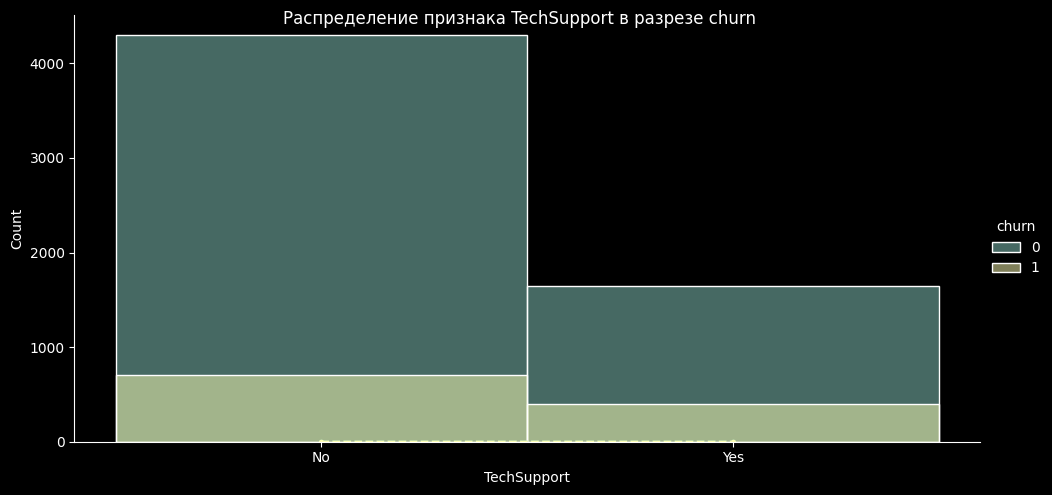

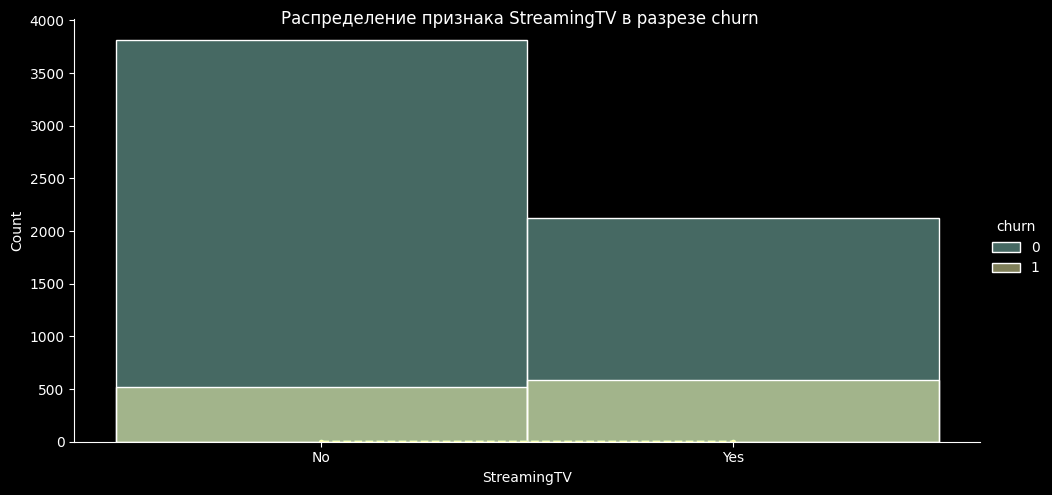

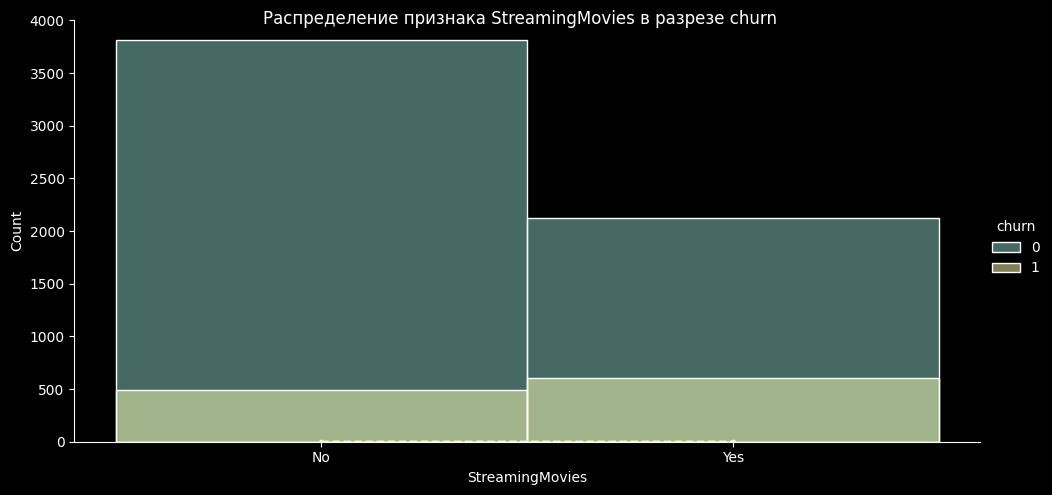

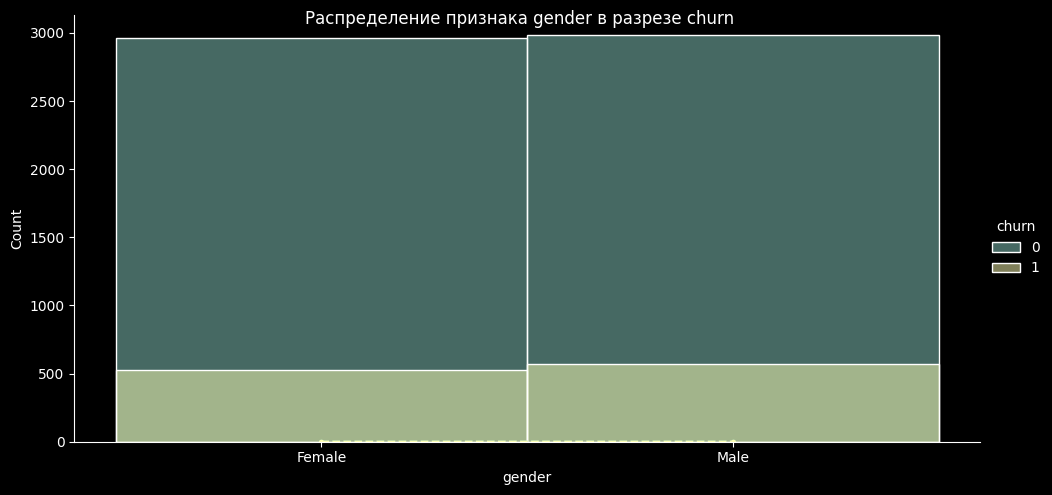

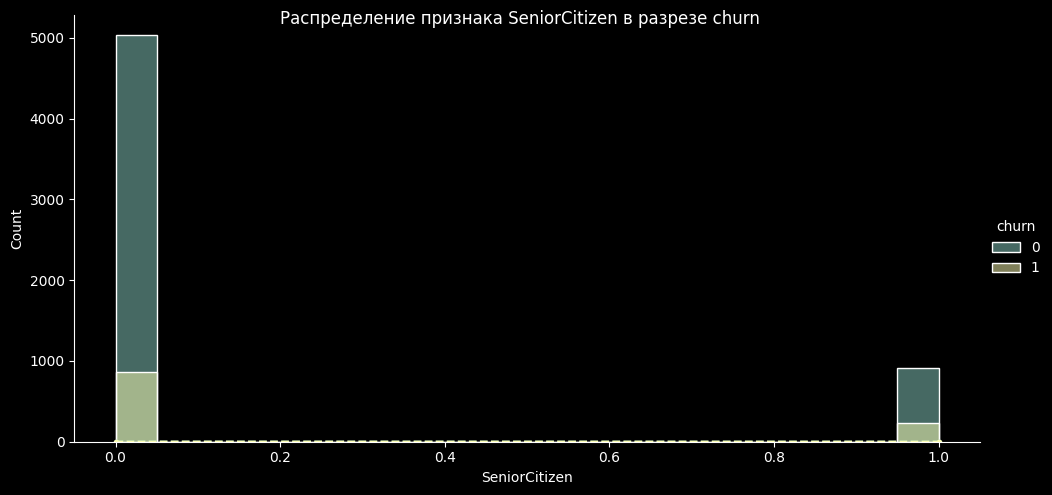

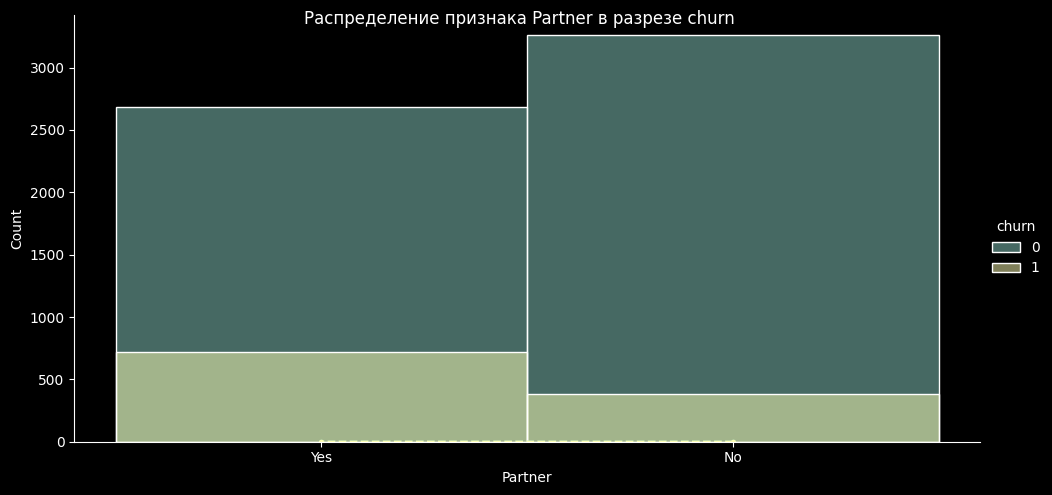

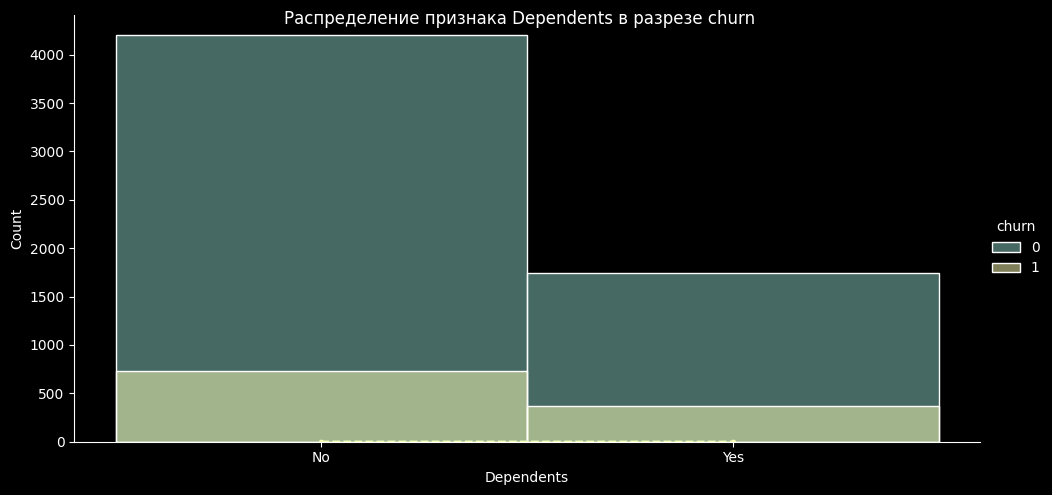

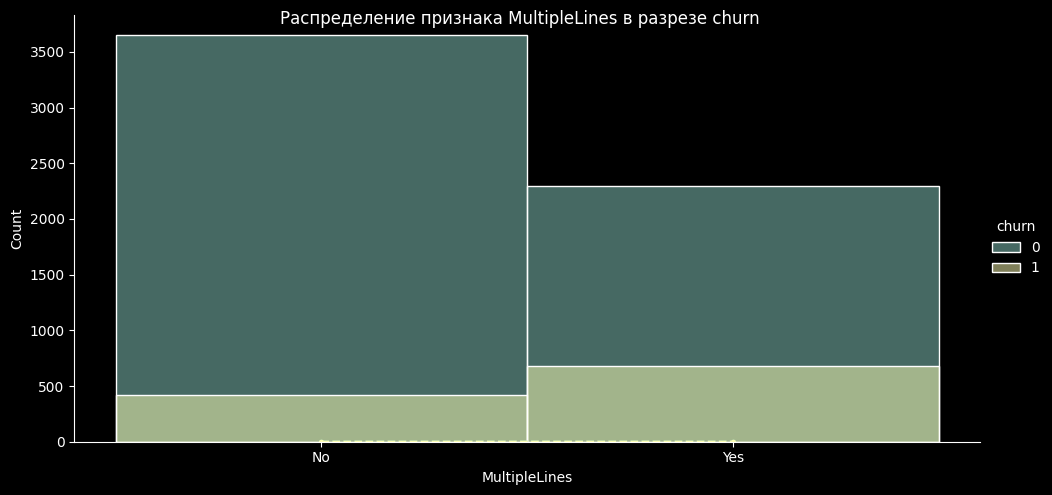

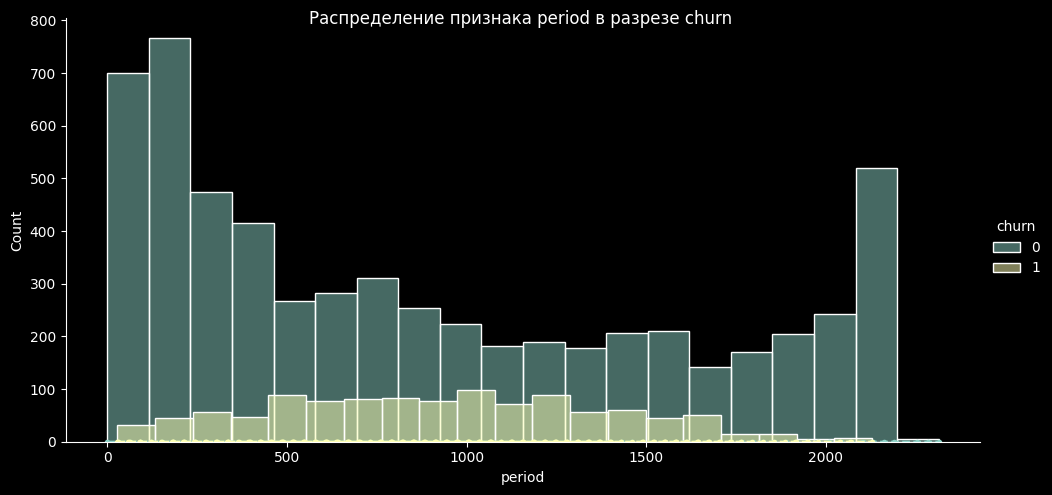

In [25]:
for col in full_data.drop(['churn'], axis=1).columns:
    plot_normalized_histogram(full_data, col)

Судя по гистограммам, незначимым признаком в наших данных является пол клиента, удалим этот признак.

In [26]:
full_data = full_data.drop('gender', axis=1)

Посмотрим, как наши признаки коррелируют между собой и с целевой переменной.

In [27]:
# строим матрицу корреляции признаков
phik_matrix = full_data.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'churn', 'SeniorCitizen', 'period']


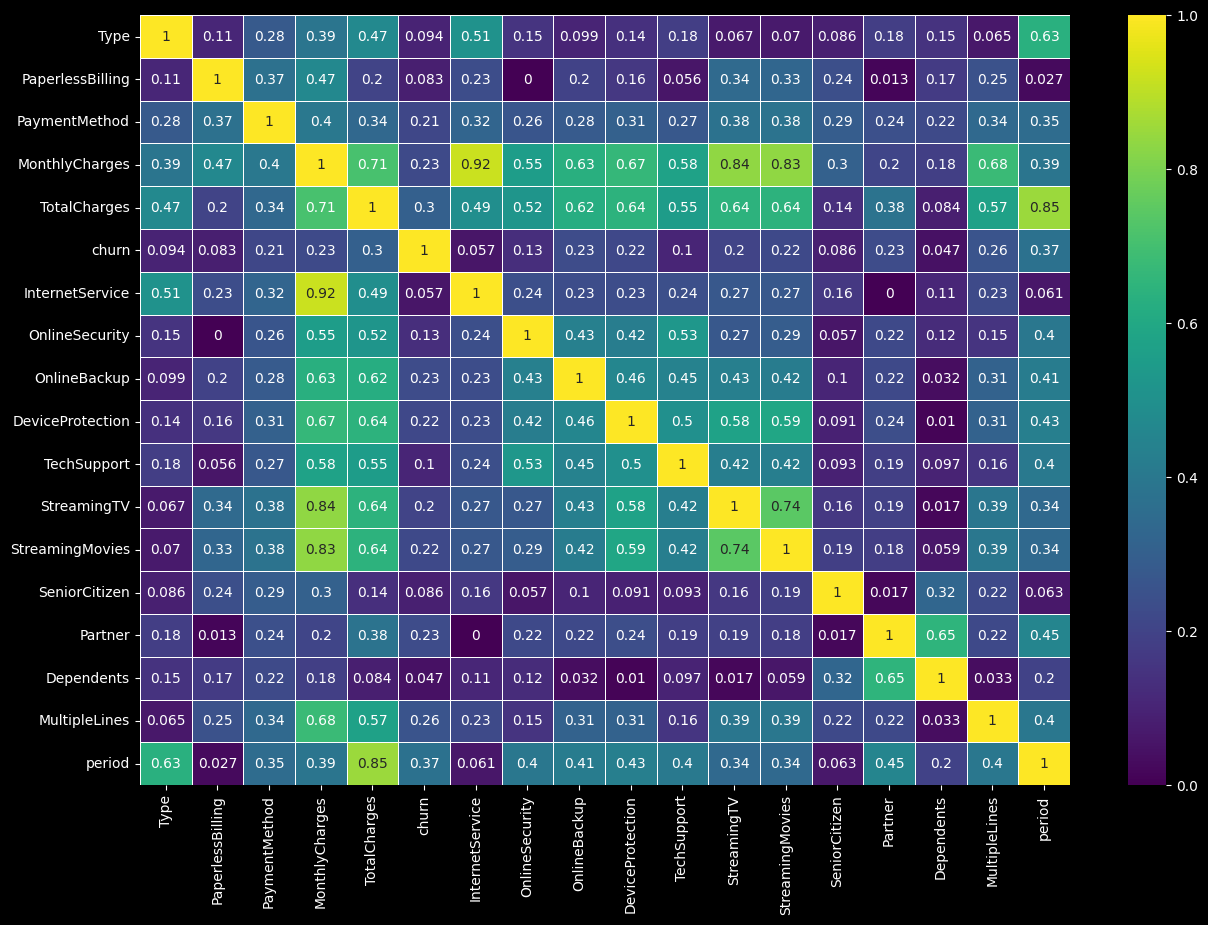

In [28]:
# строим хитмап на основе матрицы корреляции
plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix, annot=True, linewidths=.5, cmap='viridis')
plt.show()

Мы видим, что в данных есть признаки, которые сильно коррелируют между собой. Будем учитывать это при подготовке данных для обучения линейной модели.

### Вывод по разделу

На этапе обзора данных было сделано следующее:
1. Все имеющиеся датасеты объединены в один по индексу (`customerID`)
2. В результате объединения появились пропуски, которые мы заменили на _No_, предположив, что у этих клиентов не подключена данная услуга, поэтому информация о ней отсутствует
3. Был сгенерирован новый признак — `period`, отражающий время пользования услугами оператора
4. Были удалены даты начала и окончания договора
5. Были визуализированы имеющиеся признаки в разрезе целевой переменной, на основании этого удален признак `gender` как незначимый для предсказания
6. Была визуализирована матрица корреляции и сделан вывод о налчии в данных сильно коррелирующих между собой признаков

## Обучение моделей

Сделаем пустой словарь, куда будем сохранять модели и метрики.

In [29]:
models = {}

### Логистическая регрессия

#### Подготовка данных

Для линейной модели необходимо избавиться от мультиколлинеарности, т. е. удалить признаки, которые сильно коррелируют между собой. Мы будем ориентироваться на корреляцию выше 0.8. На нашей матрице корреляции видно, что в наибольшей степени с другими признаками коррелируют данные в столбцах `MonthlyCharges` и `TotalCharges`. Удалим эти признаки и посмотрим еще раз на матрицу корреляции.

In [30]:
data_lr = full_data.drop(['MonthlyCharges', 'TotalCharges'], axis=1)

In [31]:
# строим матрицу корреляции после удаления признаков
data_lr_corr_matrix = data_lr.phik_matrix()

interval columns not set, guessing: ['churn', 'SeniorCitizen', 'period']


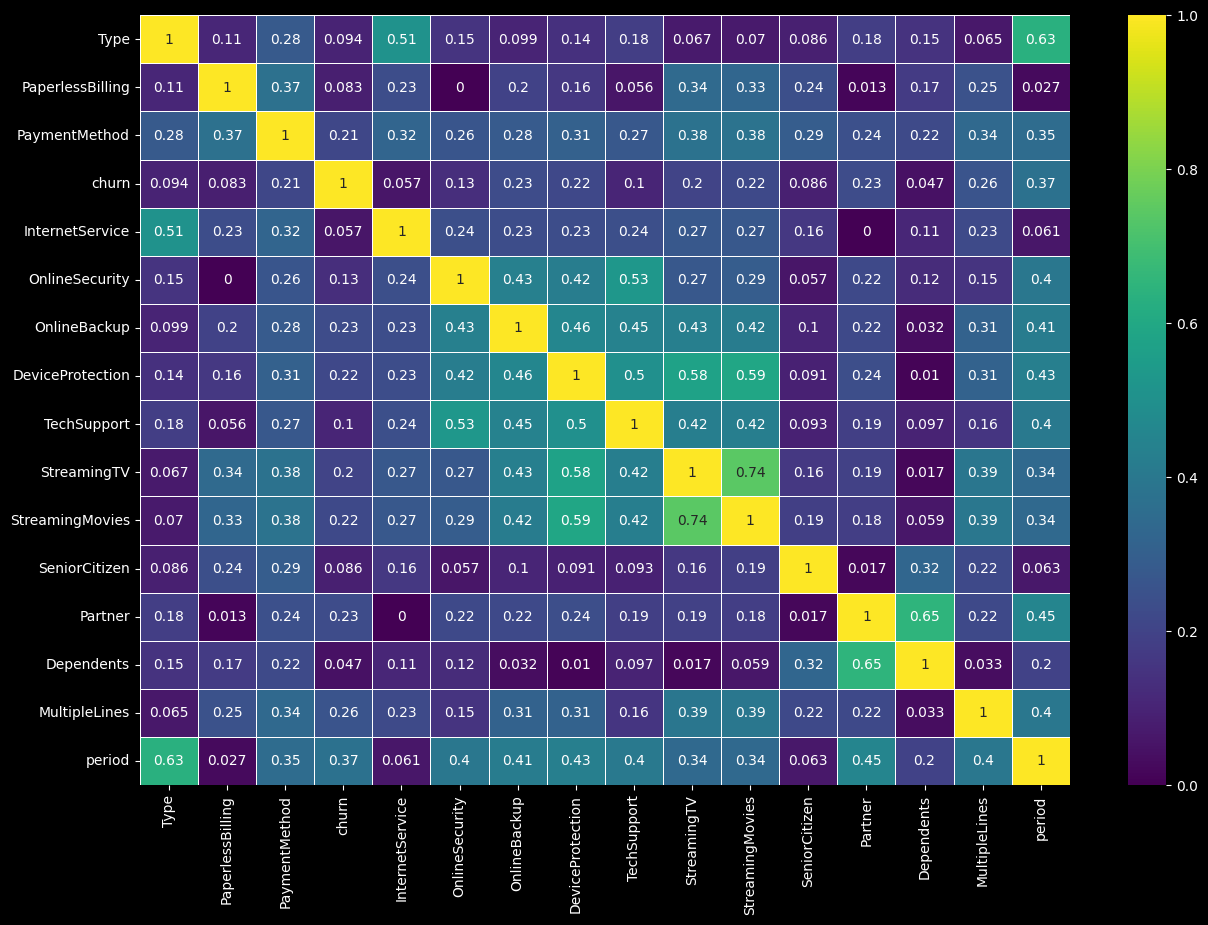

In [32]:
# строим хитмап на основе матрицы корреляции после удаления признаков
plt.figure(figsize=(15, 10))
sns.heatmap(data_lr_corr_matrix, annot=True, linewidths=.5, cmap='viridis')
plt.show()

Разобьем данные на трейн и тест.

In [33]:
# разбиваем данные на трейн и тест для модели логистической регрессии с учетом дисбаланса
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(data_lr.drop('churn', axis=1),
                                                                data_lr['churn'],
                                                                test_size=0.25,
                                                                random_state=STATE,
                                                                stratify=data_lr['churn'])

#### Обучение и оценка модели

Кодирование и масштабирование признаков, обучение и кросс-валидацию модели проведем в пайплайне.

In [34]:
cat_features = [col for col in X_train_lr.columns if X_train_lr[col].nunique() < 10 and col != 'churn']

In [35]:
# числовые признаки
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# категориальные признаки
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# объединяем числовые и категориальные признаки
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_features),
    ('num', num_transformer, ['period'])
])

# обучаем модель логистической регрессии
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

# делаем кросс-валидацию
lr_auc = cross_val_score(model_lr, X_train_lr, y_train_lr, cv=3, scoring='roc_auc',
                         verbose=10, n_jobs=-1)
lr_acc = cross_val_score(model_lr, X_train_lr, y_train_lr, cv=3, scoring='accuracy',
                         verbose=10, n_jobs=-1)




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


In [36]:
# выводим результаты
print(f'ROC-AUC модели логистической регрессии: {round(lr_auc.mean(), 3)}')
print(f'Accuracy модели логистической регрессии: {round(lr_acc.mean(), 3)}')


ROC-AUC модели логистической регрессии: 0.759
Accuracy модели логистической регрессии: 0.697


Нарисуем ROC-кривую для модели логистической регрессии.

In [37]:
# функция для рисования ROC-кривой

def draw_roc_curve(X, y, model, model_name):
    # делаем предсказания на каждом фолде и сохраняем результаты
    cv_pred = cross_val_predict(model, X, y, cv=5, method='predict_proba')
    
    # вычисляем значения для построения ROC-кривой и вычисления площади под кривой
    fpr, tpr, thresholds = roc_curve(y, cv_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # строим ROC-кривую
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая для модели ' + model_name)
    plt.legend(loc="lower right")
    

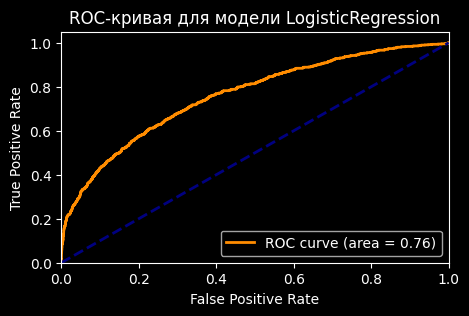

In [38]:
# выводим ROC-кривую для модели логистической регрессии
draw_roc_curve(X_train_lr, y_train_lr, model_lr, 'LogisticRegression')

In [39]:
# добавляем данные о модели логистической регрессии в словарь
models.update({'LogisticRegression': {'roc_auc': round(lr_auc.mean(), 3), 
                                      'accuracy': round(lr_acc.mean(),3)}})

### Random Forest

#### Подготовка данных

Разобьем данные на трейн и тест, коррелирующие признаки удалять не будем, поскольку модель случайного леса не чувствительна к мультиколлинеарности.

In [40]:
# разбиваем данные на трейн и тест для модели случайного леса
X_train, X_test, y_train, y_test = train_test_split(full_data.drop('churn', axis=1),
                                                    full_data['churn'],
                                                    test_size=0.25,
                                                    random_state=STATE,
                                                    stratify=data_lr['churn'])

#### Обучение и оценка модели

Для модели случайного леса будем использовать OrdinalEncoder для кодирования категориальных признаков и StandardScaler для масштабирования численных признаков (последнее не является обязательным, но может улучшить работу модели). Подберем оптимальные гиперпараметры через RandomizedSearchCV.

In [41]:
cat_features = [col for col in X_train.columns if X_train[col].nunique() < 10 and col != 'churn']

In [42]:
# числовые признаки
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# категориальные признаки
cat_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='error'))
])

# объединяем числовые и категориальные признаки
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_features),
    ('num', num_transformer, ['period'])
])

# обучаем модель случайного леса
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier())
])

# задаем сетку параметров
parameters_rf = {
    'random_forest__n_estimators' : range(10, 101),
    'random_forest__max_depth' : [None] + [i for i in range(2, 11)],
    'random_forest__min_samples_leaf' : range(10, 101)
    }

# подбираем параметры на обучающих данных
rf_search = (RandomizedSearchCV(pipe_rf,
                                param_distributions=parameters_rf,
                                scoring=['roc_auc', 'accuracy'],
                                error_score='raise',
                                refit='roc_auc',
                                n_jobs = -1,
                                random_state=STATE,
                                verbose=10).fit(X_train, y_train))    

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [43]:
# преобразовываем результаты в датафрейм
results_rf = pd.DataFrame(rf_search.cv_results_)
rf_auc = results_rf['mean_test_roc_auc'].loc[rf_search.best_index_]
rf_acc = results_rf['mean_test_accuracy'].loc[rf_search.best_index_]

# выводим результаты
print(f'ROC-AUC модели Random Forest: {round(rf_auc, 3)}')
print(f'Accuracy модели Random Forest: {round(rf_acc, 3)}')



ROC-AUC модели Random Forest: 0.829
Accuracy модели Random Forest: 0.852


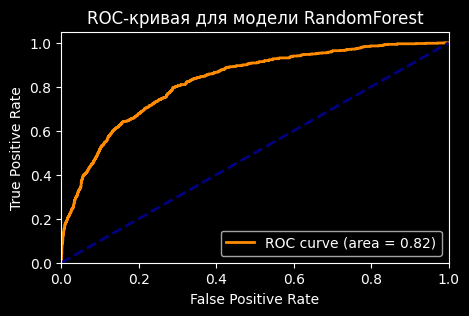

In [44]:
# строим ROC-кривую для модели случайного леса
draw_roc_curve(X_train, y_train, rf_search.best_estimator_, 'RandomForest')

In [45]:
# добавляем данные о модели RandomForest в словарь
models.update({'RandomForest': {'roc_auc': round(rf_auc, 3), 
                                'accuracy': round(rf_acc,3)}})

### LightGBM

Для модели LightGBM мы будем использовать встроенные возможности кодирования категориальных переменных. Пайплайн использовать не будем. Подберем оптимальные гиперпараметры через RandomizedSearchCV.

In [46]:
# приведем категориальные данные к типу category
cat_cols = cat_features
X_train[cat_cols] = X_train[cat_cols].astype('category')

In [47]:
# создаем модель LightGBM
model_lgb = LGBMClassifier()

# задаем сетку параметров 
params_lgb = {'n_estimators' : range(5, 200, 1),
              'max_depth' : [None] + [i for i in range(2, 11)],
              'num_leaves' : range(2, 40),
              'learning_rate' : [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8]
              }

# подбираем оптимальные параметры на обучающих данных
lgb_search = RandomizedSearchCV(model_lgb, 
                                param_distributions=params_lgb,
                                n_iter=50, 
                                cv=5, 
                                n_jobs=-1, 
                                scoring=['roc_auc', 'accuracy'],
                                refit='roc_auc',
                                random_state=STATE,
                                verbose=10).fit(X_train, y_train)




Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [48]:
# получаем гиперпараметры лучшей модели
lgb_search.best_params_

{'num_leaves': 18, 'n_estimators': 170, 'max_depth': 3, 'learning_rate': 0.45}

In [49]:
# преобразовываем результаты в датафрейм
results_lgbm = pd.DataFrame(lgb_search.cv_results_)
lgbm_auc = results_lgbm['mean_test_roc_auc'].loc[lgb_search.best_index_]
lgbm_acc = results_lgbm['mean_test_accuracy'].loc[lgb_search.best_index_]

# выводим результаты
print(f'ROC-AUC модели LightGBM: {round(lgbm_auc, 3)}')
print(f'Accuracy модели LightGBM: {round(lgbm_acc, 3)}')

ROC-AUC модели LightGBM: 0.899
Accuracy модели LightGBM: 0.911


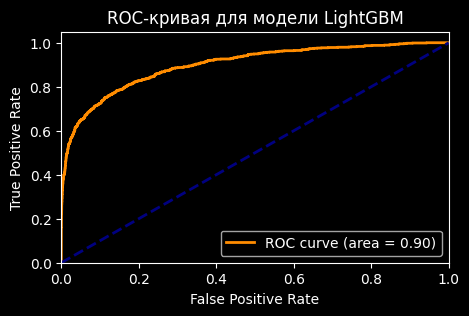

In [50]:
# рисуем ROC-кривую для модели LightGBM на обучающих данных
draw_roc_curve(X_train, y_train, lgb_search.best_estimator_, 'LightGBM')

In [51]:
# добавляем данные о модели LightGBM в словарь
models.update({'LightGBM': {'roc_auc': round(lgbm_auc, 3), 
                            'accuracy': round(lgbm_acc,3)}})

In [52]:
models

{'LogisticRegression': {'roc_auc': 0.759, 'accuracy': 0.697},
 'RandomForest': {'roc_auc': 0.829, 'accuracy': 0.852},
 'LightGBM': {'roc_auc': 0.899, 'accuracy': 0.911}}

### Обобщение метрик

In [53]:
all_models = pd.DataFrame.from_dict(models, orient='index')
all_models.style.set_caption('Метрики моделей на кросс-валидации')

,roc_auc,accuracy
LogisticRegression,0.759000,0.697000
RandomForest,0.829000,0.852000
LightGBM,0.899000,0.911000


### Вывод по разделу

На этом этапе были обучены три модели — логистическая регрессия, случайный лес и LightGBM. 
1. Для модели логистической регрессии была проведена оценка мультиколлинеарности признаков и удалены сильно коррелирующие признаки (`MonthlyCharges` и `TotalCharges`). Данные были разбиты на трейн и тест с учетом дисбаланса целевого признака, после чего в пайплайне было проведено кодирование категориальных признаков (с использованием OneHotEncoder) и масштабирование числовых признаков (с использованием StandardScaler). После обучения были получены следующие значения метрик: ROC-AUC — 0.759, accuracy — 0.697
2. Для модели случайного леса мы использовали все имеющиеся признаки, поскольку данная модель не чувствительна к мультиколлинеарности. В пайплайне было также проведено кодирование категориальных признаков (с использованием OrdinalEncoder) и масштабирование численных признаков (с использованием StandardScaler). Подбор оптимальных гиперпараметров осуществлялся с помощью RandomizedSearchCV. Эта модель показала метрики: ROC-AUC — 0.827, accuracy — 0.851
3. Для модели LightGBM мы также использовали все имеющиеся признаки. Для кодирования категориальных переменных использовался встроенный кодировщик, для этого категориальные данные были приведены к типу _category_. Подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV. Эта модель показала следующие метрики: ROC-AUC — 0.899, accuracy — 0.911

Таким образом, наилучшие значения метрик (целевой и дополнительной) были достигнуты на модели LightGBM с параметрами: {'num_leaves': 18, 'n_estimators': 170, 'max_depth': 3, 'learning_rate': 0.45}.

## Проверка лучшей модели на тестовой выборке

In [54]:
# приводим категориальные данные к типу category
X_test[cat_features] = X_test[cat_features].astype('category')

In [55]:
# выбираем лучшую модель
lgbm_best = lgb_search.best_estimator_

In [56]:
# делаем предсказания для расчета метрики roc-auc
test_pred_probs = lgbm_best.predict_proba(X_test)[:,1]

In [57]:
# делаем предсказания для расчета accuracy
test_preds = lgbm_best.predict(X_test)

In [58]:
# вычисляем метрики
test_acc = accuracy_score(y_test, test_preds)
test_auc = roc_auc_score(y_test, test_pred_probs)

In [59]:
# выводим результаты
print(f'ROC-AUC модели LightGBM на тестовой выборке: {round(test_auc, 3)}')
print(f'Accuracy модели LightGBM на тестовой выборке: {round(test_acc, 3)}')

ROC-AUC модели LightGBM на тестовой выборке: 0.894
Accuracy модели LightGBM на тестовой выборке: 0.905


Посмотрим на ROC-кривую для модели LightGBM на тестовых данных.

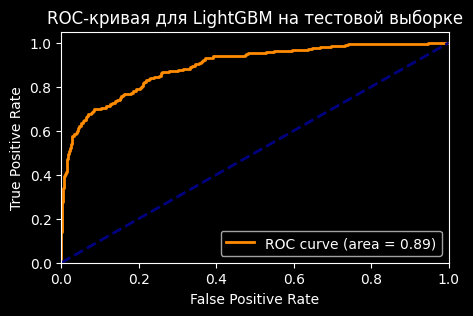

In [60]:
    # вычисляем значения для ROC-кривой
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    # строим ROC-кривую
    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая для LightGBM на тестовой выборке')
    plt.legend(loc="lower right")
    plt.show()

In [61]:
# строим матрицу ошибок
conf_matrix = confusion_matrix(y_test, test_preds)

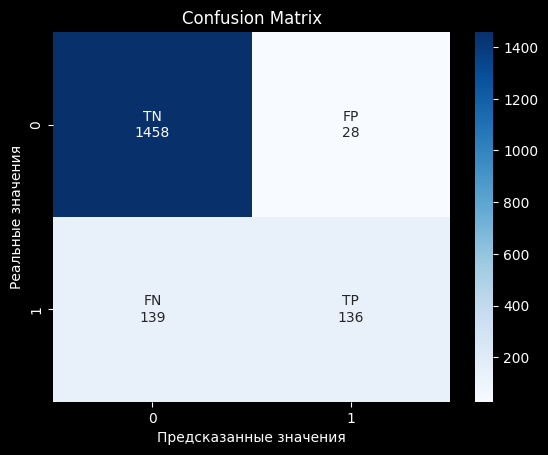

In [62]:
# визуализируем матрицу ошибок
labels = np.char.add([['TN\n', 'FP\n'],['FN\n', 'TP\n']], 
                     conf_matrix.astype('str'))

sns.heatmap(conf_matrix,
            cmap='Blues',
            annot = labels,
            fmt='')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.title('Confusion Matrix')
plt.show()



На матрице ошибок мы видим, что модель верно предсказала 136 случаев положительного класса (1 — клиент расторг договор с оператором) и 1458 случаев отрицательного класса (0 — клиент не отточный). При этом для 28 клиентов модель неверно предсказала положительный класс (по предсказаниям модели, клиент является отточным, а на самом деле нет), и для 139 клиентов модель неверно предсказала отрицательный класс (по предсказаниям модели, клиент отточным не является, тогда как на самом деле да)
.

Посмотрим, какие признаки оказались наиболее значимыми для тестовой модели.

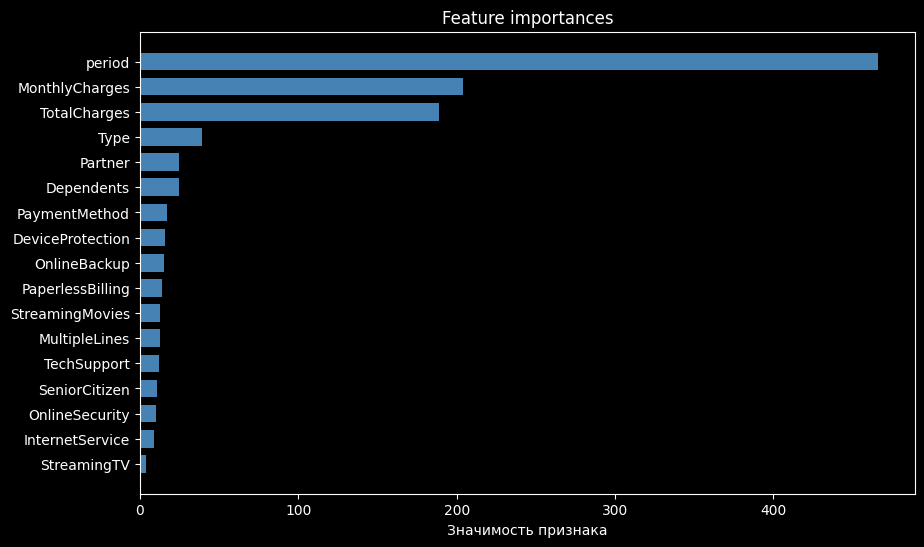

In [63]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_best.feature_importances_
})

feature_importances = (feature_importances
                       .sort_values(by='importance', ascending=True)
)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], 
         feature_importances['importance'], 
         height=0.7, 
         color='steelblue')
plt.xlabel('Значимость признака')
plt.title('Feature importances')
plt.show()

Наиболее значимыми для этой модели оказались признаки: `period`, `MonthlyCharges`, `TotalCharges`, `Type`, `Partner`. Обучим тестовую модель с использованием топ-5 значимых признаков.

In [64]:
# выделяем топ-5 значимых признаков
top_5 = feature_importances.sort_values(by='importance', ascending=False)[:5]
top_5['feature'].to_list()

['period', 'MonthlyCharges', 'TotalCharges', 'Type', 'Partner']

In [65]:
# оставляем только значимые признаки в выборках
X_train_new = X_train[top_5['feature'].to_list()]
X_test_new = X_test[top_5['feature'].to_list()]

In [66]:
# обучаем модель на новых признаках
model_lgb_new = LGBMClassifier(**lgb_search.best_params_)
model_lgb_new.fit(X_train_new, y_train)

# делаем предсказания для расчета метрики auc-roc
test_preds_proba_new = model_lgb_new.predict_proba(X_test_new)[:,1]

# делаем предсказания для расчета accuracy
test_preds_new = model_lgb_new.predict(X_test_new)

In [67]:
# вычисляеем метрики
test_acc_new = accuracy_score(y_test, test_preds_new)
test_auc_new = roc_auc_score(y_test, test_preds_proba_new)

In [68]:
# сравниваем метрики до и после удаления признаков
print(f'ROC-AUC модели LightGBM на тестовой выборке до удаления признаков: {round(test_auc, 3)}')
print(f'Accuracy модели LightGBM на тестовой выборке до удаления признаков: {round(test_acc, 3)}')
print(f'ROC-AUC модели LightGBM на тестовой выборке после удаления признаков: {round(test_auc_new, 3)}')
print(f'Accuracy модели LightGBM на тестовой выборке после удаления признаков: {round(test_acc_new, 3)}')

ROC-AUC модели LightGBM на тестовой выборке до удаления признаков: 0.894
Accuracy модели LightGBM на тестовой выборке до удаления признаков: 0.905
ROC-AUC модели LightGBM на тестовой выборке после удаления признаков: 0.892
Accuracy модели LightGBM на тестовой выборке после удаления признаков: 0.918


Как видим, после удаления незначимых признаков метрика ROC-AUC снизилась незначительно (на 2 тысячные), а метрика accuracy выросла.

### Вывод по разделу
На этом этапе лучшая модель (LightGBM) была протестирована на тестовой выборке. Данная модель показала значения метрик: ROC-AUC — 0.894, accuracy — 0.905.

Результаты модели были визуализированы с помощью ROC-кривой и матрицы ошибок. 

Также была проведена оценка важности признаков. Наиболее значимыми для этой модели оказались признаки: `period`, `MonthlyCharges`, `TotalCharges`, `Type`, `Partner`. После этого тестовая модель была обучена с использованием только этих признаков и показала следующие метрики: ROC-AUC — 0.892,
accuracy — 0.918.

#Отчет по проекту

Нашей **целью** в этом проекте было обучение и выбор оптимальной модели для предсказания возможного оттока клиентов.

**Этапы проекта:**

1. Загрузили данные и спарсили даты
2. Провели первичную предобработку данных 
3. Сформировали целевой признак и обнаружили наличие дисбаланса
4. Объединили данные из четырех датасетов в один
5. Обработали пропущенные значения
6. Проанализировали признаки в разрезе целевой переменной и удалили незначимый признак (`gender`)
7. Сгенерировали новый признак на основе дат (`period`) и удалили даты
8. Оценили корреляцию признаков (обнаружили мультиколлинеарность)
9. Закодировали категориальные признаки
10. Обучили три модели (`LogisticRegression`, `RandomForestClassifier` и `LGBMClassifier`) и проверили их метрики на кросс-валидации
11. Проверили наиболее оптимальную модель на тестовой выборке, добились нужного результата
12. Проанализировали матрицу ошибок
13. Оценили важность признаков и обучили модель на топ-5 значимых признаков

В нашем распоряжении было четыре датасета:

- `contract` — данные о контрактах
- `internet` — данные о подключенных интернет-услугах
- `persons` — персональные данные клиентов
- `phone` — данные о подключенных услугах телефонии


Все имеющиеся датасеты объединены в один по индексу (`customerID`).

**В ходе предобработки данных были обнаружены следующие проблемы:**

1. Тип данных в столбце `TotalCharges` не соответствовал значениям в столбце (там содержались дробные числа, тогда как тип данных был _object_), при попытке изменить тип данных на числовой возникала ошибка, связанная с тем, что в некоторых ячейках имелись пустые строки

2. После объединения датафреймов в сводной таблице образовались пропуски

3. В данных не был обнаружен целевой признак для классификации

4. В данных имелись столбцы с датами, которые могли отрицательно повлиять на предсказания модели, поскольку данная задача не является задачей прогнозирования временных рядов и в результате могла возникнуть ложная корреляция. Вместе с тем время прихода клиента в компанию и ухода из нее может оказаться крайне значимым для предсказания

5. Возможно, не все признаки являются значимыми для модели и некоторые можно удалить

**Для решения этих проблем мы предприняли следующие шаги:**

1. Проанализировали данные и пришли к выводу, что пустые строки соответствуют новым клиентам, т. е. тем, которые еще не успели совершить оплату, поэтому эти пропуски были заменены на `0`, после чего тип данных был изменен на _float_

2. Пропуски, появившиеся после объединения данных, мы заменили на _No_, предположив, что у этих клиентов не подключена данная услуга, поэтому информация о ней отсутствует

3. Целевой признак для классификации был сгенерирован на основе данных из столбца `EndDate`: мы заменили все даты на значение `1` (клиент ушел), а значение _No_ — на `0` (клиент все еще пользуется услугами компании)

4. На основе данных из столбцов `BeginDate` и `EndDate` был сгенерирован новый признак — `period`, отражающий время пользования услугами оператора. Были удалены даты начала и окончания договора

5. Были визуализированы имеющиеся признаки в разрезе целевой переменной, на основании этого удален признак `gender` как незначимый для предсказания



**Итоговый список признаков после предобработки данных**

|Признак|Описание|
|:--------|---------:|
| period | Сколько дней клиент пользуется услугами оператора|
|Type | Тип оплаты|
|PaperlessBilling | Безналичный расчет|
|PaymentMethod | Cпособ оплаты|
|MonthlyCharges | Ежемесячные траты|
|OnlineSecurity | Блокировка небезопасных сайтов|
|OnlineBackup | Облачное хранилище|
|DeviceProtection | Антивирус|
|TechSupport | Техническая поддержка|
|SeniorCitizen | Пенсионный статус|
|Partner | Наличие супруга|
|Dependents | Наличие детей|
|MultipleLines | Параллельные линии во время звонка|
|churn | Отточный или неотточный клиент|

Таким образом, в ходе предобработки и подготовки признаков было сделано следующее:

1. Обработка пропусков (пропуски были заменены на значение _No_, исходя из предположения, что отсутствие данных связано с тем, что клиент этой услугой не пользуется)
2. Удаление незначимого признака (`gender`) после визуализации данных в разрезе целевой переменной
3. Генерирование нового признака (период нахождения клиента в компании) на основе дат, а затем удаление этих дат
4. Кодирование категориальных данных с использованием OneHotEncoder, OrdinalEncoder, а также встроенных возможностей для модели LightGBM
5. Для модели логистической регрессии — удаление коррелирующих с другими признаков (`MonthlyCharges` и `TotalCharges`)

Для решения задачи классификации мы обучили три модели:

- `LogisticRegression`
- `RandomForestClassifier`
- `LightGBM`

1. Для модели логистической регрессии была проведена оценка мультиколлинеарности признаков и удалены сильно коррелирующие признаки (`MonthlyCharges` и `TotalCharges`). Данные были разбиты на трейн и тест, после чего в пайплайне было проведено кодирование категориальных признаков (с использованием OneHotEncoder) и масштабирование числовых признаков (с использованием StandardScaler). После обучения были получены следующие значения метрик: `ROC-AUC` — 0.759, `accuracy` — 0.697

2. Для модели случайного леса мы использовали все имеющиеся признаки, поскольку данная модель не чувствительна к мультиколлинеарности. В пайплайне было также проведено кодирование категориальных признаков (с использованием OrdinalEncoder) и масштабирование численных признаков (с использованием StandardScaler). Подбор оптимальных гиперпараметров осуществлялся с помощью RandomizedSearchCV. Эта модель показала метрики: `ROC-AUC` — 0.826, `accuracy` — 0.851

3. Для модели LightGBM мы также использовали все имеющиеся признаки. Для кодирования категориальных переменных использовался встроенный кодировщик, для этого категориальные данные были приведены к типу _category_. Подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV. Эта модель показала следующие метрики: `ROC-AUC` — 0.899, `accuracy` — 0.911

Приведем значения метрик, полученных на кросс-валидации:

|Модель|ROC-AUC |Accuracy|
|:--------|---------|---------|
| LogisticRegression | 0.759| 0.697|
|RandomForestClassifier | 0.826 | 0.851|
|LightGBM | 0.899 | 0.911|

Таким образом, наилучшие значения метрик (целевой и дополнительной) были достигнуты на модели LightGBM с параметрами: 

- 'num_leaves': 18, 
- 'n_estimators': 170, 
- 'max_depth': 3, 
- 'learning_rate': 0.45

Лучшая модель (LightGBM) была протестирована на тестовой выборке, где показала значения метрик (на всех признаках): `ROC-AUC` — 0.894, `accuracy` — 0.905. Посмотрим на матрицу ошибок.



[![confusion-matrix.png](https://i.postimg.cc/25m46sFv/confusion-matrix.png)](https://postimg.cc/gxSwtB7k)

На матрице ошибок мы видим, что модель верно предсказала 136 случаев положительного класса (1 — клиент расторг договор с оператором) и 1458 случаев отрицательного класса (0 — клиент не отточный). При этом для 28 клиентов модель неверно предсказала положительный класс (по предсказаниям модели, клиент является отточным, а на самом деле нет), и для 139 клиентов модель неверно предсказала отрицательный класс (по предсказаниям модели, клиент отточным не является, тогда как на самом деле да)
.

Далее мы проанализировали важность признаков. Посмотрим на график.

[![feature-importance.png](https://i.postimg.cc/fWc2X59p/feature-importance.png)](https://postimg.cc/kD5vPQwv)

Наиболее значимыми для этой модели оказались признаки: `period` (время пользования услугами компании), `MonthlyCharges` (месячная оплата), `TotalCharges` (общая сумма оплаты), `Type` (тип оплаты), `Partner` (наличие супруга). Тестовая модель была обучена с использованием только этих топ-5 значимых признаков и показала следующие метрики: `ROC-AUC` — 0.892, `accuracy` — 0.918.

Таким образом, мы достигли необходимого порога по основной метрике (`ROC-AUC`) и получили хорошие результаты по дополнительной метрике (`accuracy`). 

Работа была выполнена в соответствии с планом, существенных отклонений от плана не было.

Обученная нами модель может использоваться в бизнесе для прогнозирования возможного оттока клиентов. 